In [12]:
import xgboost as xgb
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from datetime import datetime
import numpy as np
from scipy.sparse import csr_matrix

In [3]:
def parse_date(date_str):
    for fmt in ('%Y-%m-%d %H:%M', '%Y-%m-%d'):
        try:
            return datetime.strptime(date_str, fmt)
        except ValueError:
            continue
    print(f"Failed to parse date: {date_str}")
    return None

In [4]:
csv_files = [
    'English_common_species_file_L128530.csv', 'English_common_species_file_L162766.csv', 'English_common_species_file_L207315.csv',
    'English_common_species_file_L232479.csv', 'English_common_species_file_L257959.csv', 'English_common_species_file_L269461.csv',
    'English_common_species_file_L298030.csv', 'English_common_species_file_L321969.csv', 'English_common_species_file_L351484.csv'
]

In [5]:
df_list = [pd.read_csv(file) for file in csv_files]
df = pd.concat(df_list, ignore_index=True)

# Strip extra spaces from column names
df.columns = df.columns.str.strip()

# Ensure 'Observation Date' column is parsed correctly as datetime
df['Observation Date'] = pd.to_datetime(df['Observation Date'], errors='coerce')

In [6]:
# Check if there are any missing values after parsing
df = df.dropna(subset=['Observation Date'])  # Drop rows with invalid dates

# Feature Engineering: Extract relevant features from 'Observation Date'
df['Hour'] = df['Observation Date'].dt.hour
df['Day'] = df['Observation Date'].dt.day
df['Month'] = df['Observation Date'].dt.month
df['Year'] = df['Observation Date'].dt.year

In [7]:
# Handle categorical features (Location and Species) by encoding them

df['Location'] = df['Location'].astype('category').cat.codes
df['Species'] = df['Species'].astype('category').cat.codes

# Calculate species counts
species_counts = df['Species'].value_counts()
print(species_counts)

# Filter species based on the threshold
threshold = 6
valid_species = species_counts[species_counts >= threshold].index
print(valid_species)

# Filter the dataframe
df_filtered = df[df['Species'].isin(valid_species)]

# Recalculate species counts in the filtered dataset
filtered_counts = df_filtered['Species'].value_counts()
print(filtered_counts)

# Ensure all species meet the threshold
if any(filtered_counts < threshold):
    raise ValueError("Some species in the filtered dataset have counts below the threshold.")

# Prepare your features and labels
X = df_filtered[['Hour', 'Day', 'Month', 'Year',  'Location']]  # Add 'Latitude' and 'Longitude'
y = df_filtered['Species']  # Target variable (Species)

Species
85     8
7      8
26     8
47     8
127    7
      ..
84     1
123    1
44     1
95     1
113    1
Name: count, Length: 207, dtype: int64
Index([ 85,   7,  26,  47, 127, 145,  80, 177, 194,  34,  72,  12,  31,  86,
       169,  88,  14, 102, 135, 118, 101, 204, 181, 182,  42,  73,  51,  71,
       156,  48,  20, 130,  87, 174,  78,  62,  58,  64,  30],
      dtype='int16', name='Species')
Species
47     8
85     8
26     8
7      8
127    7
86     7
169    7
118    7
101    7
88     7
31     7
181    7
12     7
80     7
145    7
204    7
34     7
102    7
135    7
42     7
72     7
194    7
177    7
14     7
182    7
20     6
48     6
156    6
71     6
87     6
62     6
73     6
58     6
174    6
130    6
51     6
78     6
64     6
30     6
Name: count, dtype: int64


In [8]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(y_train.value_counts())


Species
177    7
72     7
135    7
169    7
118    7
181    7
7      7
73     6
86     6
130    6
12     6
194    6
85     6
31     6
101    6
20     6
78     6
14     6
26     6
64     6
127    6
34     5
204    5
182    5
87     5
145    5
80     5
102    5
48     5
51     4
71     4
88     4
58     4
30     4
47     4
174    4
156    4
62     3
42     2
Name: count, dtype: int64


In [13]:
X_train_optimized = X_train.copy()
X_train_optimized['Hour'] = X_train_optimized['Hour'].astype('int8')  # Reduce memory usage for 'int' columns
X_train_optimized['Day'] = X_train_optimized['Day'].astype('int8')
X_train_optimized['Month'] = X_train_optimized['Month'].astype('int8')
X_train_optimized['Year'] = X_train_optimized['Year'].astype('int16')  # Reduce memory usage
X_train_optimized['Location'] = X_train_optimized['Location'].astype('int8')

# 2. Convert data to sparse matrix if it is sparse
X_train_sparse = csr_matrix(X_train_optimized)

# 3. Convert y_train to a lower memory type
y_train_optimized = y_train.astype('int16')

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [76]:
print("Number of unique classes in filtered dataset:", len(df_filtered['Species'].unique()))

Number of unique classes in filtered dataset: 39


In [78]:
import psutil
import os

# Print memory usage of the variables
print(f"Memory usage of X_train: {psutil.Process(os.getpid()).memory_info().rss / 1024 ** 2} MB")
print(f"Memory usage of DMatrix objects: {psutil.Process(os.getpid()).memory_info().rss / 1024 ** 2} MB")


Memory usage of X_train: 236.3515625 MB
Memory usage of DMatrix objects: 236.3515625 MB


In [77]:
# Define hyperparameters for the model
params = {
    'objective': 'multi:softmax',  # Multi-class classification
    'num_class': len(np.unique(y_train)),  # Dynamically set the number of classes
    'max_depth': 8,  # Maximum depth of the trees
    'eta': 0.1,  # Learning rate (step size)
    'subsample': 1,  # Fraction of samples to use for each tree
    'colsample_bytree': 1,  # Fraction of features to use for each tree
    'eval_metric': 'merror',  # Error rate metric for multi-class classification
    'seed': 42  # Random seed for reproducibility
}

# Train the XGBoost model with the given hyperparameters
num_round = 100  # Number of boosting rounds (trees)
evals = [(dtrain, 'train'), (dtest, 'test')]
bst = xgb.train(params, dtrain, num_round, evals=evals, verbose_eval=10)

# Make predictions on the test set
y_pred = bst.predict(dtest)
print("Predictions (y_pred):", y_pred[:10])

# No need to convert to integers if the model is set to 'multi:softmax'
# Ensure that predictions are already integer class labels
# Evaluate the model's performance using accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Feature importance plot (optional)
import matplotlib.pyplot as plt
xgb.plot_importance(bst)
plt.show()

XGBoostError: [04:01:08] /workspace/src/objective/multiclass_obj.cu:111: SoftmaxMultiClassObj: label must be in [0, num_class).
Stack trace:
  [bt] (0) /home/grace/bird-forecast/xgboost/lib/python3.11/site-packages/xgboost/lib/libxgboost.so(+0x22dcbc) [0x72a0a662dcbc]
  [bt] (1) /home/grace/bird-forecast/xgboost/lib/python3.11/site-packages/xgboost/lib/libxgboost.so(+0xc02147) [0x72a0a7002147]
  [bt] (2) /home/grace/bird-forecast/xgboost/lib/python3.11/site-packages/xgboost/lib/libxgboost.so(+0x5cb173) [0x72a0a69cb173]
  [bt] (3) /home/grace/bird-forecast/xgboost/lib/python3.11/site-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x6f) [0x72a0a653752f]
  [bt] (4) /home/grace/anaconda3/lib/python3.11/lib-dynload/../../libffi.so.8(+0xa052) [0x72a10c012052]
  [bt] (5) /home/grace/anaconda3/lib/python3.11/lib-dynload/../../libffi.so.8(+0x8925) [0x72a10c010925]
  [bt] (6) /home/grace/anaconda3/lib/python3.11/lib-dynload/../../libffi.so.8(ffi_call+0xde) [0x72a10c01106e]
  [bt] (7) /home/grace/anaconda3/lib/python3.11/lib-dynload/_ctypes.cpython-311-x86_64-linux-gnu.so(+0x92e4) [0x72a10c0222e4]
  [bt] (8) /home/grace/anaconda3/lib/python3.11/lib-dynload/_ctypes.cpython-311-x86_64-linux-gnu.so(+0x8836) [0x72a10c021836]



In [24]:
# Check the unique values in y_test and y_pred
print(f"Unique values in y_test: {np.unique(y_test)}")
print(f"Unique values in y_pred: {np.unique(y_pred)}")

Unique values in y_test: [  7  12  14  26  30  31  34  42  47  48  51  58  62  71  80  85  86  87
  88 101 102 127 145 156 174 182 194 204]
Unique values in y_pred: [  7  14  31  48  51  64  73  78  80  85  86  87 101 118 130 135 182 194]


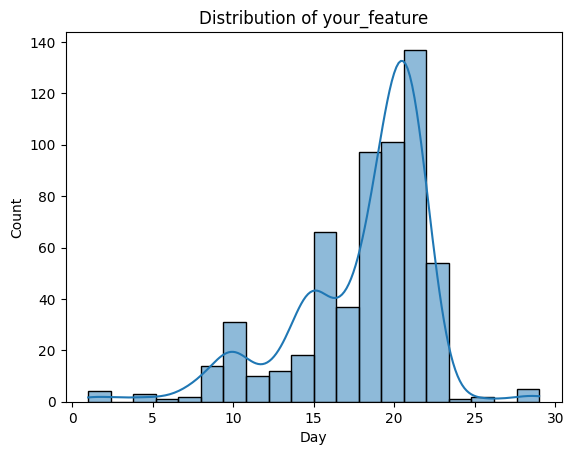

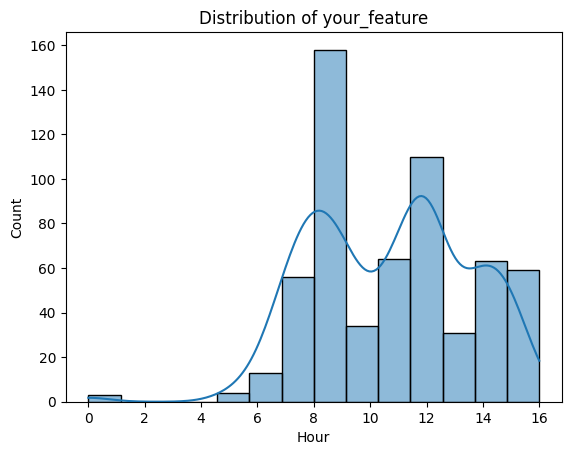

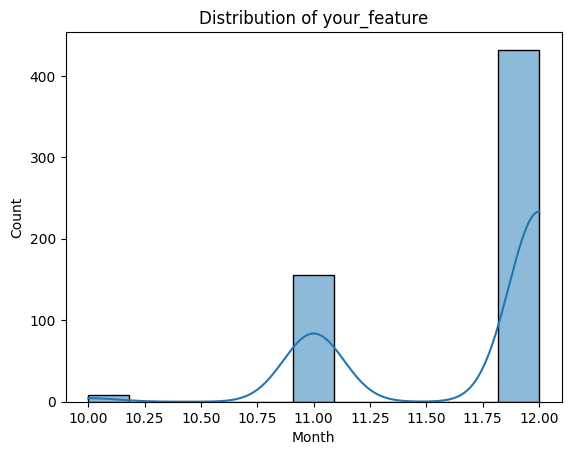

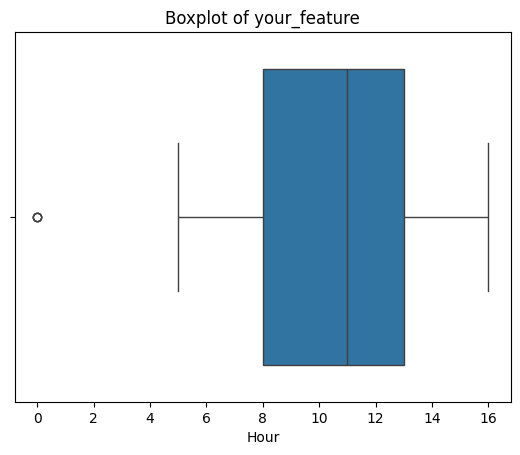

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the distribution using a histogram
sns.histplot(df['Day'], kde=True)
plt.title('Distribution of your_feature')
plt.show()

sns.histplot(df['Hour'], kde=True)
plt.title('Distribution of your_feature')
plt.show()

sns.histplot(df['Month'], kde=True)
plt.title('Distribution of your_feature')
plt.show()

# Box plot to check for outliers
sns.boxplot(x=df['Hour'])
plt.title('Boxplot of your_feature')
plt.show()